In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import gc
import time
from pandas.core.common import SettingWithCopyWarning
import warnings
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

# notebook settings
warnings.simplefilter('error', SettingWithCopyWarning)
gc.enable()
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# set path
PATH = '../../data/ga_revenue/'

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", FutureWarning)


In [2]:
def get_folds(df = None, n_splits = 5):
    
    # Get sorted unique visitors
    unique_vis = np.array(sorted(df['fullVisitorId'].unique()))

    # Get folds
    folds = GroupKFold(n_splits=n_splits)
    fold_ids = []
    ids = np.arange(df.shape[0])
    for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
        fold_ids.append(
            [
                ids[df['fullVisitorId'].isin(unique_vis[trn_vis])],
                ids[df['fullVisitorId'].isin(unique_vis[val_vis])]
            ]
        )

    return fold_ids

# LightGBM Feature Importance

## Load Data

In [4]:
df = pd.read_feather(PATH+'feathers/joined_processed_all_feateng_float32_noinf')

train = deepcopy(df[df['dataset'] == 'train'])
test = deepcopy(df[df['dataset'] == 'test'])
del df

# drop dataset identifier and reset index
train.drop('dataset', axis = 1, inplace = True)
test.drop('dataset', axis = 1, inplace = True)
train.reset_index(drop = True, inplace = True)
test.reset_index(drop = True, inplace = True)

/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


## Folding Strategy

In [27]:
def get_folds(df = None, n_splits = 5):
    
    # Get sorted unique visitors
    unique_vis = np.array(sorted(df['fullVisitorId'].unique()))

    # Get folds
    folds = GroupKFold(n_splits=n_splits)
    fold_ids = []
    ids = np.arange(df.shape[0])
    for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
        fold_ids.append(
            [
                ids[df['fullVisitorId'].isin(unique_vis[trn_vis])],
                ids[df['fullVisitorId'].isin(unique_vis[val_vis])]
            ]
        )

    return fold_ids

### Get Session Target

In [6]:
y_reg = train['totals.transactionRevenue'].fillna(0)
del train['totals.transactionRevenue']

if 'totals.transactionRevenue' in test.columns:
    del test['totals.transactionRevenue']

## Create Features Lists

In [102]:
categorical_features = [
    
    'channelGrouping', 'visitNumber', 'device.browser', 'device.deviceCategory',
    'device.isMobile', 'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.continent',
    'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
    'geoNetwork.subContinent', 'trafficSource.adContent', 'trafficSource.adwordsClickInfo.adNetworkType',
    'trafficSource.adwordsClickInfo.gclId', 'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.slot',
    'trafficSource.campaign', 'trafficSource.keyword', 'trafficSource.medium', 'trafficSource.referralPath',
    'trafficSource.source', 'visitStartTimeLOCALYear', 'visitStartTimeLOCALMonth', 'visitStartTimeLOCALWeek',
    'visitStartTimeLOCALDay', 'visitStartTimeLOCALDayofweek', 'visitStartTimeLOCALDayofyear', 'visitStartTimeLOCALIs_month_end',
    'visitStartTimeLOCALIs_month_start', 'visitStartTimeLOCALIs_quarter_end', 'visitStartTimeLOCALIs_quarter_start',
    'visitStartTimeLOCALIs_year_end', 'visitStartTimeLOCALIs_year_start', 'visitStartTimeLOCALHourofday',
    
    'return_visit', 'landing', 'bounce', 'user_has_purchased_before', 'browser_os', 'browser_device', 'os_device',
    'channel_device', 'channel_domain', 'city_country_mismatch', 'is_holiday', 'netflix_internet_speed_index_BIN20',
    'mobile_subs_per_100_BIN20', 'tel_subs_per_100_BIN20', 'internet_usage_pct_BIN20', 'broadband_subs_per_100_BIN20',
    'gdp_per_capita_BIN20', 'gdp_per_capita_growth_BIN20', 'high_tech_exports_BIN20'
    
]

contin_features = [
    
    'totals.hits', 'totals.pageviews', 'days_after_holiday', 'days_before_holiday', 'holiday_anticipation',
    'holiday_gap', 'days_since_last_visit', 'days_since_first_visit', 'netflix_internet_speed_index',
    'mobile_subs_per_100', 'tel_subs_per_100', 'internet_usage_pct', 'broadband_subs_per_100', 'gdp_per_capita',
    'gdp_per_capita_growth', 'high_tech_exports'
    
]

excluded_features = [
    
    'date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 'visitId',
    'visitStartTime', 'visitStartTimeLOCAL', 'visitStartTimeLOCALElapsed'

]

# set remaining cols as continuous
additional_contin_vars = deepcopy([c for c in train.columns
                                   if c not in categorical_features + contin_features + excluded_features
                                  ])

# add the additional engineered cols to continuous
contin_features += additional_contin_vars

## Factorize Categoricals

In [8]:
for f in categorical_features:
    train[f], indexer = pd.factorize(train[f])
    if test[f].dtype == bool:
        test[f] = indexer.get_indexer(deepcopy(test[f].astype(int)))
    else:
        test[f] = indexer.get_indexer(test[f])

In [9]:
train.shape, test.shape

((903653, 955), (804684, 955))

In [10]:
train_features = [_f for _f in train.columns if _f not in excluded_features]
X_train, y_train = train[train_features], y_reg

## Set Hyperparamaters

In [12]:
n_estimators = 10000

params = {
    'learning_rate': 0.01,
    'objective':'regression',
    'metric':'rmse',
    'num_leaves': 54,
    'verbose': 1,
    'bagging_fraction': 0.99,
    'feature_fraction': 0.99,
    "random_state":42,
    'max_depth': 15,
    "bagging_seed" : 42,
    "verbosity" : -1,
    "bagging_frequency" : 5,
    'lambda_l2': 0.5,
    'lambda_l1': 0.5,
    'min_child_samples': 36
}

# Train & Validate

## 10k Estimators

In [14]:
folds = get_folds(df=train, n_splits = 5)

train_features = [_f for _f in train.columns if _f not in excluded_features]

importances = pd.DataFrame()
oof_reg_preds = np.zeros(train.shape[0])
sub_reg_preds = np.zeros(test.shape[0])

for fold_, (trn_, val_) in enumerate(folds):
    
    print("Fold:",fold_)
    trn_x, trn_y = train[train_features].iloc[trn_], y_reg.iloc[trn_]
    val_x, val_y = train[train_features].iloc[val_], y_reg.iloc[val_]
    
    # init & fit
    print('Fitting model...')
    reg = lgb.LGBMRegressor(**params, n_estimators = n_estimators)
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(val_x, np.log1p(val_y))],
        early_stopping_rounds=50,
        verbose=100,
        eval_metric='rmse'
    )
    
    # feature importance
    imp_df = pd.DataFrame()
    imp_df['feature'] = train_features
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    oof_reg_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_reg_preds[oof_reg_preds < 0] = 0
    _preds = reg.predict(test[train_features], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    sub_reg_preds += np.expm1(_preds) / len(folds)
    
mean_squared_error(np.log1p(y_reg), oof_reg_preds) ** .5

## Plot Feature Importance

In [ ]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

importances['gain_log'] = np.log1p(importances['gain'])
mean_gain = importances[['gain', 'feature']].groupby('feature').mean()
importances['mean_gain'] = importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(8, 12))
sns.barplot(x = 'gain_log',
            y = 'feature',
            data = importances.sort_values('mean_gain', ascending = False)[:400]
           );

In [32]:
sorted_importances = importances.sort_values('mean_gain', ascending = False)[['feature', 'mean_gain']].drop_duplicates().reset_index(drop = True)

In [34]:
sorted_importances.to_csv('feature_importances_5000est.csv', index = False)

## 10k Estimators

In [11]:
folds = get_folds(df = train, n_splits = 8)

train_features = [_f for _f in train.columns if _f not in excluded_features]

importances = pd.DataFrame()
oof_reg_preds = np.zeros(train.shape[0])
sub_reg_preds = np.zeros(test.shape[0])

for fold_, (trn_, val_) in enumerate(folds):
    
    print("Fold:",fold_)
    trn_x, trn_y = train[train_features].iloc[trn_], y_reg.iloc[trn_]
    val_x, val_y = train[train_features].iloc[val_], y_reg.iloc[val_]
    
    # init & fit
    print('Fitting model...')
    reg = lgb.LGBMRegressor(**params, n_estimators = 10000)
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(val_x, np.log1p(val_y))],
        early_stopping_rounds=50,
        verbose=100,
        eval_metric='rmse'
    )
    
    # feature importance
    imp_df = pd.DataFrame()
    imp_df['feature'] = train_features
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    oof_reg_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_reg_preds[oof_reg_preds < 0] = 0
    _preds = reg.predict(test[train_features], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    sub_reg_preds += np.expm1(_preds) / len(folds)
    
mean_squared_error(np.log1p(y_reg), oof_reg_preds) ** .5

Fold: 0
Fitting model...
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.6594
[200]	valid_0's rmse: 1.58114
[300]	valid_0's rmse: 1.55692
[400]	valid_0's rmse: 1.54778
[500]	valid_0's rmse: 1.5426
[600]	valid_0's rmse: 1.54023
[700]	valid_0's rmse: 1.53805
[800]	valid_0's rmse: 1.53603
[900]	valid_0's rmse: 1.53444
[1000]	valid_0's rmse: 1.53327
[1100]	valid_0's rmse: 1.53247
[1200]	valid_0's rmse: 1.53146
[1300]	valid_0's rmse: 1.53054
[1400]	valid_0's rmse: 1.52985
Early stopping, best iteration is:
[1398]	valid_0's rmse: 1.52982
Fold: 1
Fitting model...
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.67287
[200]	valid_0's rmse: 1.59612
[300]	valid_0's rmse: 1.57306
[400]	valid_0's rmse: 1.56629
[500]	valid_0's rmse: 1.5618
[600]	valid_0's rmse: 1.55885
[700]	valid_0's rmse: 1.55676
[800]	valid_0's rmse: 1.55552
[900]	valid_0's rmse: 1.55486
[1000]	valid_0's rmse: 1.55406
[1100]	valid_0's rmse: 1.55381
[1200]

2.8393023560320083

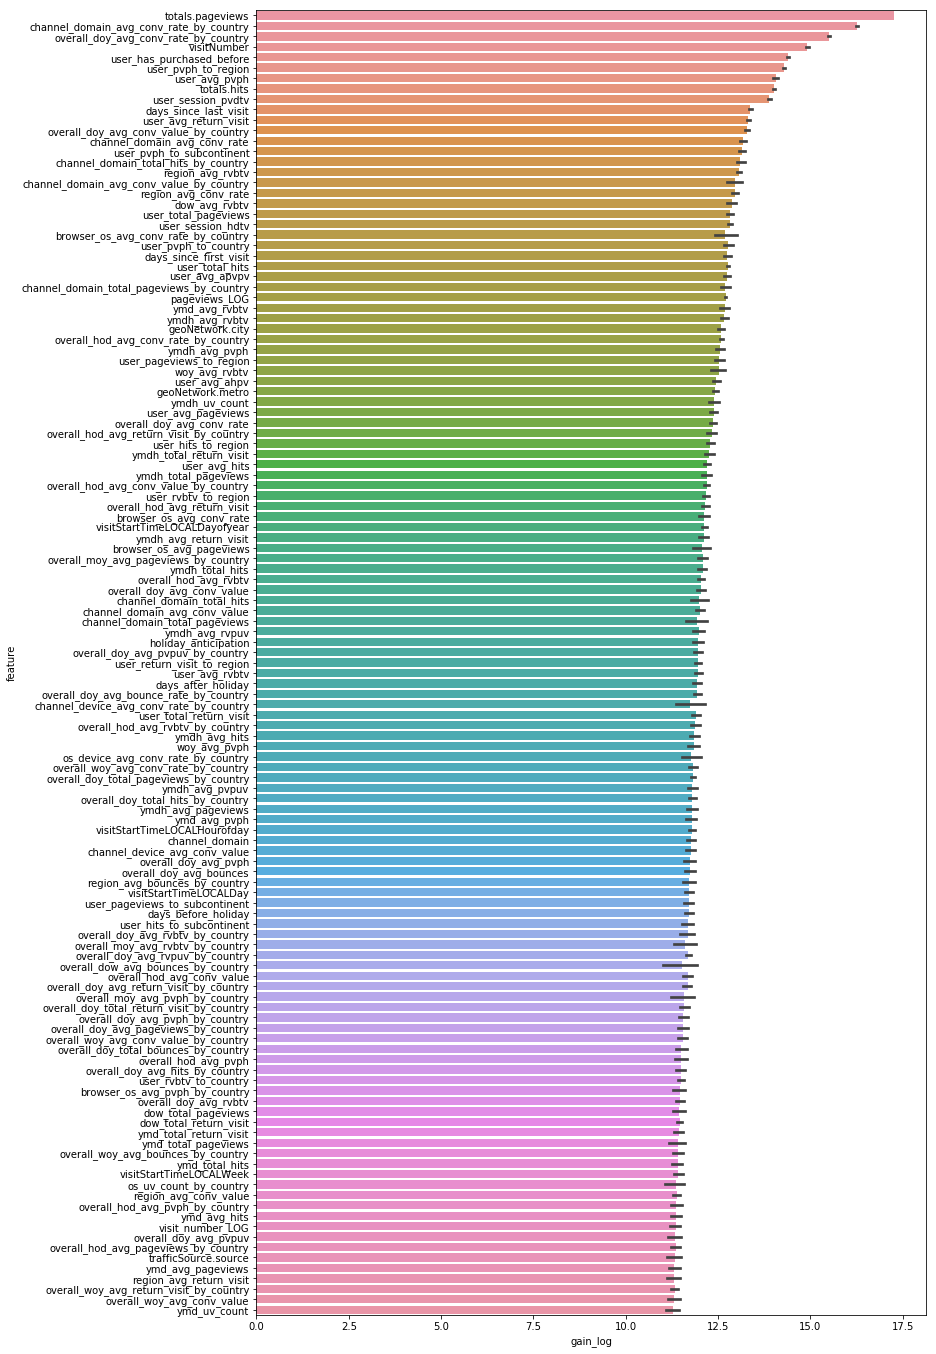

In [19]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

importances['gain_log'] = np.log1p(importances['gain'])
mean_gain = importances[['gain', 'feature']].groupby('feature').mean()
importances['mean_gain'] = importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(12, 24))
sns.barplot(x = 'gain_log',
            y = 'feature',
            data = importances.sort_values('mean_gain', ascending = False)[:1000]
           );

In [23]:
sorted_importances = importances.sort_values('mean_gain', ascending = False)[['feature', 'mean_gain']].drop_duplicates().reset_index(drop = True)
len(sorted_importances[sorted_importances.mean_gain < 0.00000001]) / len(sorted_importances)

0.2088607594936709

In [14]:
sorted_importances.to_csv('feature_importances_10000est.csv', index = False)

# Identify Important Feature Groups

In [27]:
sorted_importances_5k = pd.read_csv('feature_importances_5000est.csv')
sorted_importances_10k = pd.read_csv('feature_importances_10000est.csv')

sorted_importances_5k.index = sorted_importances_5k['feature']
sorted_importances_10k.index = sorted_importances_10k['feature']
sorted_importances_5k.drop('feature', 1, inplace = True)
sorted_importances_10k.drop('feature', 1, inplace = True)

In [28]:
sorted_importances = sorted_importances_10k.join(sorted_importances_5k, lsuffix='_10k', rsuffix='_5k').copy()
sorted_importances['mean_gain_sum'] = sorted_importances.mean_gain_10k + sorted_importances.mean_gain_5k
sorted_importances = sorted_importances.drop(['mean_gain_10k', 'mean_gain_5k'], 1).sort_values('mean_gain_sum', ascending = False)
sorted_importances['feature'] = sorted_importances.index
sorted_importances.reset_index(drop = True, inplace = True)

In [29]:
len(sorted_importances[sorted_importances.mean_gain_sum > 100]['feature'].tolist())

725

In [22]:
len(sorted_importances['feature'].tolist())

948

# Feature Category Importance

In [30]:
#df = pd.read_feather(PATH+'feathers/joined_processed_all_feateng_float32_noinf')

In [34]:
full_col_list = train.columns.tolist()

In [35]:
col_org = {
    
    'site_metrics': ['visitNumber', 'return_visit', 'landing', 'bounce', 'user_has_purchased_before',
                     'totals.hits', 'totals.pageviews', 'days_since_last_visit', 'days_since_first_visit',
                     'pageviews_LOG', 'hits_LOG', 'visit_number_LOG', 'return_visit_LOG',
                     'days_since_last_visit_LOG', 'days_since_first_visit_LOG', 'landing_LOG'
                    ],
    
    'economic': ['netflix_internet_speed_index_BIN20', 'mobile_subs_per_100_BIN20', 'tel_subs_per_100_BIN20',
                 'internet_usage_pct_BIN20', 'broadband_subs_per_100_BIN20', 'gdp_per_capita_BIN20',
                 'gdp_per_capita_growth_BIN20', 'high_tech_exports_BIN20', 'netflix_internet_speed_index',
                 'mobile_subs_per_100', 'tel_subs_per_100', 'internet_usage_pct', 'broadband_subs_per_100',
                 'gdp_per_capita', 'gdp_per_capita_growth', 'high_tech_exports'
                ],
    
    'holiday': ['is_holiday', 'days_after_holiday', 'days_before_holiday', 'holiday_anticipation', 'holiday_gap'],
    
    'date_based': ['visitStartTimeLOCALYear', 'visitStartTimeLOCALMonth', 'visitStartTimeLOCALWeek',
                   'visitStartTimeLOCALDay', 'visitStartTimeLOCALDayofweek', 'visitStartTimeLOCALDayofyear',
                   'visitStartTimeLOCALIs_month_end', 'visitStartTimeLOCALIs_month_start', 'visitStartTimeLOCALIs_quarter_end',
                   'visitStartTimeLOCALIs_quarter_start', 'visitStartTimeLOCALIs_year_end', 'visitStartTimeLOCALIs_year_start',
                   'visitStartTimeLOCALHourofday'
                  ],
    
    'browser_based': ['device.browser', 'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
                      'browser_os', 'browser_device', 'os_device'
                     ],
    
    'domainchannel_based': ['channelGrouping', 'channel_device', 'channel_domain'],
    
    'geo_based': ['geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro',
                  'geoNetwork.networkDomain', 'geoNetwork.region', 'geoNetwork.subContinent', 'city_country_mismatch'
                 ],
    
    'user_based': [],
    
    'conv_based': [],
    
    'traffic_source': ['trafficSource.adContent', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.gclId',
                       'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
                       'trafficSource.keyword', 'trafficSource.medium', 'trafficSource.referralPath', 'trafficSource.source'
                      ]
    
}

exclude_cols = [
    
    'dataset', 'date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 'visitId',
    'visitStartTime', 'visitStartTimeLOCAL', 'visitStartTimeLOCALElapsed'

]

In [36]:
# get list of cols not yet categorized
categorized_col_list = []
for cat, cols in col_org.items(): categorized_col_list += cols
remaining_col_list = [c for c in full_col_list if c not in categorized_col_list and c not in exclude_cols]

# create "filters" for each of the col categories
user_col_filters = ['user_']
conv_col_filters = ['_conv']
date_col_filter = ['year_', 'ym_', 'ymd_', 'ymdh_', 'dow_', 'woy_', 'hod_', 'doy_', 'moy_']
browser_col_filter = ['browser', 'device', 'os_']
domainchannel_col_filter = ['domain', 'channel']
geo_col_filters = ['region_', 'country_', 'subcontinent_']

# add the non-categorized cols to a category based on filter
for col in remaining_col_list:
    
    added = False
    
    for f in user_col_filters:
        if f in col:
            col_org['user_based'].append(col)
            added = True
        if added: break
    
    if not added:
        for f in conv_col_filters:
            if f in col:
                col_org['conv_based'].append(col)
                added = True
            if added: break
    
    if not added:
        for f in date_col_filter:
            if f in col:
                col_org['date_based'].append(col)
                added = True
            if added: break
    
    if not added:
        for f in domainchannel_col_filter:
            if f in col:
                col_org['domainchannel_based'].append(col)
                added = True
            if added: break
    
    if not added:
        for f in browser_col_filter:
            if f in col:
                col_org['browser_based'].append(col)
                added = True
            if added: break
    
    if not added:
        for f in geo_col_filters:
            if f in col:
                col_org['geo_based'].append(col)
                added = True
            if added: break

# check once more if there are any cols that aren't categorized
categorized_col_list = []
for cat, cols in col_org.items(): categorized_col_list += cols
remaining_col_list = [c for c in full_col_list if c not in categorized_col_list and c not in exclude_cols]; remaining_col_list

[]

In [37]:
col_org

{'site_metrics': ['visitNumber',
  'return_visit',
  'landing',
  'bounce',
  'user_has_purchased_before',
  'totals.hits',
  'totals.pageviews',
  'days_since_last_visit',
  'days_since_first_visit',
  'pageviews_LOG',
  'hits_LOG',
  'visit_number_LOG',
  'return_visit_LOG',
  'days_since_last_visit_LOG',
  'days_since_first_visit_LOG',
  'landing_LOG'],
 'economic': ['netflix_internet_speed_index_BIN20',
  'mobile_subs_per_100_BIN20',
  'tel_subs_per_100_BIN20',
  'internet_usage_pct_BIN20',
  'broadband_subs_per_100_BIN20',
  'gdp_per_capita_BIN20',
  'gdp_per_capita_growth_BIN20',
  'high_tech_exports_BIN20',
  'netflix_internet_speed_index',
  'mobile_subs_per_100',
  'tel_subs_per_100',
  'internet_usage_pct',
  'broadband_subs_per_100',
  'gdp_per_capita',
  'gdp_per_capita_growth',
  'high_tech_exports'],
 'holiday': ['is_holiday',
  'days_after_holiday',
  'days_before_holiday',
  'holiday_anticipation',
  'holiday_gap'],
 'date_based': ['visitStartTimeLOCALYear',
  'visitSta

In [55]:
category_importance = {'site_metrics': 0, 'economic': 0, 'holiday': 0, 'date_based': 0, 'browser_based': 0,
                       'domainchannel_based': 0, 'geo_based': 0, 'user_based': 0, 'conv_based': 0, 'traffic_source': 0}

for category in list(col_org.keys()):
    for feature in col_org[category]:
        print(feature)
        _importance = float(sorted_importances[sorted_importances['feature'] == feature]['mean_gain_sum'])
        category_importance[category] += _importance

visitNumber
return_visit
landing
bounce
user_has_purchased_before
totals.hits
totals.pageviews
days_since_last_visit
days_since_first_visit
pageviews_LOG
hits_LOG
visit_number_LOG
return_visit_LOG
days_since_last_visit_LOG
days_since_first_visit_LOG
landing_LOG
netflix_internet_speed_index_BIN20
mobile_subs_per_100_BIN20
tel_subs_per_100_BIN20
internet_usage_pct_BIN20
broadband_subs_per_100_BIN20
gdp_per_capita_BIN20
gdp_per_capita_growth_BIN20
high_tech_exports_BIN20
netflix_internet_speed_index
mobile_subs_per_100
tel_subs_per_100
internet_usage_pct
broadband_subs_per_100
gdp_per_capita
gdp_per_capita_growth
high_tech_exports
is_holiday
days_after_holiday
days_before_holiday
holiday_anticipation
holiday_gap
visitStartTimeLOCALYear
visitStartTimeLOCALMonth
visitStartTimeLOCALWeek
visitStartTimeLOCALDay
visitStartTimeLOCALDayofweek
visitStartTimeLOCALDayofyear
visitStartTimeLOCALIs_month_end
visitStartTimeLOCALIs_month_start
visitStartTimeLOCALIs_quarter_end
visitStartTimeLOCALIs_quart

channel_device_total_hits
channel_domain_total_hits
domain_total_return_visit
channel_total_return_visit
channel_device_total_return_visit
channel_domain_total_return_visit
domain_avg_pageviews
channel_avg_pageviews
channel_device_avg_pageviews
channel_domain_avg_pageviews
domain_avg_hits
channel_avg_hits
channel_device_avg_hits
channel_domain_avg_hits
domain_avg_return_visit
channel_avg_return_visit
channel_device_avg_return_visit
channel_domain_avg_return_visit
domain_avg_pvph
channel_avg_pvph
channel_device_avg_pvph
channel_domain_avg_pvph
domain_avg_pvpuv
channel_avg_pvpuv
channel_device_avg_pvpuv
channel_domain_avg_pvpuv
domain_avg_rvpuv
channel_avg_rvpuv
channel_device_avg_rvpuv
channel_domain_avg_rvpuv
domain_avg_rvbtv
channel_avg_rvbtv
channel_device_avg_rvbtv
channel_domain_avg_rvbtv
domain_uv_count_by_country
channel_uv_count_by_country
channel_device_uv_count_by_country
channel_domain_uv_count_by_country
domain_total_pageviews_by_country
channel_total_pageviews_by_country
ch

In [57]:
mean_category_importance = {}

for cat, imp in category_importance.items():
    mean_category_importance[cat] = float(category_importance[cat] / len(col_org[cat]))

In [61]:
pd.Series(mean_category_importance).sort_values(ascending = False)

site_metrics           4.685867e+06
conv_based             3.908934e+05
user_based             3.622330e+05
holiday                1.947359e+05
date_based             9.277076e+04
geo_based              5.409285e+04
domainchannel_based    3.581859e+04
traffic_source         3.438617e+04
browser_based          1.413710e+04
economic               3.058038e+02
dtype: float64

In [65]:
sorted_importances[sorted_importances['feature'].isin(col_org['site_metrics'])]

,mean_gain_sum,feature
0,6.055149e+07,totals.pageviews
3,5.834276e+06,visitNumber
4,3.438647e+06,user_has_purchased_before
7,2.367826e+06,totals.hits
9,1.258301e+06,days_since_last_visit
26,6.677336e+05,days_since_first_visit
29,6.312694e+05,pageviews_LOG
117,1.791801e+05,visit_number_LOG
362,1.979859e+04,hits_LOG
396,1.441076e+04,days_since_last_visit_LOG


In [72]:
sorted_importances[sorted_importances['feature'].isin(col_org['conv_based'])].reset_index(drop = True)[:26]

,mean_gain_sum,feature
0,2.214677e+07,channel_domain_avg_conv_rate_by_country
1,1.058025e+07,overall_doy_avg_conv_rate_by_country
2,1.159535e+06,overall_doy_avg_conv_value_by_country
3,1.053486e+06,channel_domain_avg_conv_rate
4,8.686114e+05,channel_domain_avg_conv_value_by_country
5,8.450111e+05,region_avg_conv_rate
6,7.520807e+05,browser_os_avg_conv_rate_by_country
7,5.891378e+05,overall_hod_avg_conv_rate_by_country
8,4.747683e+05,overall_doy_avg_conv_rate
9,3.893341e+05,overall_hod_avg_conv_value_by_country


In [76]:
sorted_importances[sorted_importances['feature'].isin(col_org['user_based'])].reset_index(drop = True)

,mean_gain_sum,feature
0,3.088377e+06,user_pvph_to_region
1,2.509801e+06,user_avg_pvph
2,2.140221e+06,user_session_pvdtv
3,1.189896e+06,user_avg_return_visit
4,1.089972e+06,user_pvph_to_subcontinent
5,7.638773e+05,user_session_hdtv
6,7.359484e+05,user_total_pageviews
7,7.030337e+05,user_total_hits
8,6.947674e+05,user_pvph_to_country
9,6.591039e+05,user_avg_apvpv


In [67]:
sorted_importances[sorted_importances['feature'].isin(col_org['holiday'])]

,mean_gain_sum,feature
57,334074.932852,holiday_anticipation
62,323940.868660,days_after_holiday
82,253860.481625,days_before_holiday
241,61166.134010,holiday_gap
624,636.911396,is_holiday


In [95]:
sorted_importances[sorted_importances['feature'].isin(col_org['date_based'])].reset_index(drop = True)[:10]

,mean_gain_sum,feature
0,758206.030152,dow_avg_rvbtv
1,676760.944299,ymdh_avg_rvbtv
2,645536.512234,ymd_avg_rvbtv
3,627194.355563,ymdh_avg_pvph
4,553424.749525,woy_avg_rvbtv
5,508369.601189,ymdh_uv_count
6,436571.950028,ymdh_total_return_visit
7,432263.535391,overall_hod_avg_return_visit_by_country
8,419119.221203,ymdh_total_pageviews
9,393360.849057,ymdh_avg_return_visit


In [94]:
sorted_importances[sorted_importances['feature'].isin(col_org['geo_based'])].reset_index(drop = True)[:10]

,mean_gain_sum,feature
0,886374.362750,region_avg_rvbtv
1,585140.781719,geoNetwork.city
2,496021.539310,geoNetwork.metro
3,237278.538520,region_avg_bounces_by_country
4,185303.548087,region_avg_return_visit
5,156146.713836,region_total_bounces_by_country
6,82471.715866,region_avg_pvph
7,80055.714102,region_avg_bounces
8,71685.410457,region_avg_rvpuv
9,68326.712870,geoNetwork.networkDomain


In [96]:
sorted_importances[sorted_importances['feature'].isin(col_org['domainchannel_based'])].reset_index(drop = True)[:10]

,mean_gain_sum,feature
0,937550.256870,channel_domain_total_hits_by_country
1,710347.453367,channel_domain_total_pageviews_by_country
2,296111.406583,channel_domain_total_hits
3,294878.893060,channel_domain_total_pageviews
4,251330.354681,channel_domain
5,166334.688695,channel_domain_total_return_visit_by_country
6,138907.759579,channel_domain_avg_rvbtv
7,130086.645466,channel_domain_avg_bounces_by_country
8,128967.765281,channel_domain_avg_pageviews_by_country
9,123568.088672,channel_domain_avg_pvpuv_by_country


In [103]:
# add cols from best performing categories
site_metric_cols = [c for c in
                    sorted_importances[sorted_importances['feature'].isin(col_org['site_metrics'])]['feature']
                    if 'LOG' not in c]

conv_cols = [c for c in 
             sorted_importances[sorted_importances['feature'].isin(col_org['conv_based'])].reset_index(drop = True)[:26]['feature']
             if 'LOG' not in c]

user_cols = [c for c in
             sorted_importances[sorted_importances['feature'].isin(col_org['user_based'])].reset_index(drop = True)[:25]['feature']
             if 'LOG' not in c]

holiday_cols = sorted_importances[sorted_importances['feature'].isin(col_org['holiday'])]['feature'].tolist()

# add top five from less "important categories"
date_cols = sorted_importances[sorted_importances['feature'].isin(col_org['date_based'])].reset_index(drop = True)[:5]['feature'].tolist()
geo_cols = sorted_importances[sorted_importances['feature'].isin(col_org['geo_based'])].reset_index(drop = True)[:5]['feature'].tolist()
dc_cols = sorted_importances[sorted_importances['feature'].isin(col_org['domainchannel_based'])].reset_index(drop = True)[:5]['feature'].tolist()

# add all together and remove any categorical cols
polynomial_cols = [col for col in site_metric_cols + conv_cols + user_cols + holiday_cols + date_cols + geo_cols + dc_cols if col not in categorical_features]

# filter down to top 50 for memory limits
polynomial_cols = deepcopy(sorted_importances[sorted_importances['feature'].isin(polynomial_cols)].reset_index(drop = True)[:49]['feature'].tolist() + ['days_before_holiday'])

# Create Polynomial Features

In [3]:
df = pd.read_feather(PATH+'feathers/joined_processed_all_feateng_float32_noinf')

/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [4]:
# polynomial_cols = ['totals.pageviews', 'channel_domain_avg_conv_rate_by_country', 'overall_doy_avg_conv_rate_by_country',
#                     'visitNumber', 'user_has_purchased_before', 'user_pvph_to_region', 'user_avg_pvph', 'totals.hits',
#                     'user_session_pvdtv', 'days_since_last_visit', 'user_avg_return_visit', 'overall_doy_avg_conv_value_by_country',
#                     'channel_domain_avg_conv_rate', 'user_pvph_to_subcontinent', 'channel_domain_total_hits_by_country', 'region_avg_rvbtv',
#                     'channel_domain_avg_conv_value_by_country', 'region_avg_conv_rate', 'dow_avg_rvbtv', 'user_total_pageviews',
#                     'user_session_hdtv', 'browser_os_avg_conv_rate_by_country', 'user_pvph_to_country', 'days_since_first_visit',
#                     'user_total_hits', 'user_avg_apvpv', 'channel_domain_total_pageviews_by_country'
#                    ]

In [5]:
polynomial_cols = [
    
    'totals.pageviews', 'channel_domain_avg_conv_rate_by_country', 'overall_doy_avg_conv_rate_by_country',
    'user_pvph_to_region', 'user_avg_pvph', 'totals.hits', 'user_session_pvdtv', 'days_since_last_visit',
    'user_avg_return_visit', 'overall_doy_avg_conv_value_by_country', 'user_pvph_to_subcontinent',
    'channel_domain_avg_conv_rate', 'channel_domain_total_hits_by_country', 'region_avg_rvbtv',
    'channel_domain_avg_conv_value_by_country', 'region_avg_conv_rate', 'user_session_hdtv', 'dow_avg_rvbtv',
    'browser_os_avg_conv_rate_by_country', 'user_total_pageviews', 'channel_domain_total_pageviews_by_country',
    'user_total_hits', 'user_pvph_to_country', 'ymdh_avg_rvbtv', 'days_since_first_visit', 'user_avg_apvpv',
    'ymd_avg_rvbtv', 'ymdh_avg_pvph', 'overall_hod_avg_conv_rate_by_country', 'user_pageviews_to_region',
    'woy_avg_rvbtv', 'user_avg_pageviews', 'user_avg_ahpv', 'overall_doy_avg_conv_rate', 'user_hits_to_region',
    'user_avg_hits', 'user_rvbtv_to_region', 'overall_hod_avg_conv_value_by_country', 'browser_os_avg_conv_rate',
    'overall_doy_avg_conv_value', 'channel_domain_avg_conv_value', 'holiday_anticipation', 'user_return_visit_to_region',
    'channel_device_avg_conv_rate_by_country', 'days_after_holiday', 'user_avg_rvbtv', 'user_total_return_visit',
    'channel_domain_total_hits', 'channel_domain_total_pageviews', 'days_before_holiday'

]

In [6]:
# filter down to poly cols only
prepoly_df = deepcopy(df[polynomial_cols])
del df

# create df with new polynomial cols
poly = PolynomialFeatures(degree = 2, interaction_only = True).fit(deepcopy(prepoly_df))
features = pd.DataFrame(poly.transform(prepoly_df), columns = poly.get_feature_names(prepoly_df.columns))

# drop the original cols
features.drop(polynomial_cols + ['1'], 1, inplace = True)

# fill spaces in col names
col_name_edit = [c.replace(' ', '*') for c in features.columns.tolist()]
features.columns = col_name_edit

In [7]:
features.head()

,totals.pageviews*channel_domain_avg_conv_rate_by_country,totals.pageviews*overall_doy_avg_conv_rate_by_country,totals.pageviews*user_pvph_to_region,totals.pageviews*user_avg_pvph,totals.pageviews*totals.hits,totals.pageviews*user_session_pvdtv,totals.pageviews*days_since_last_visit,totals.pageviews*user_avg_return_visit,totals.pageviews*overall_doy_avg_conv_value_by_country,totals.pageviews*user_pvph_to_subcontinent,...,user_avg_rvbtv*user_total_return_visit,user_avg_rvbtv*channel_domain_total_hits,user_avg_rvbtv*channel_domain_total_pageviews,user_avg_rvbtv*days_before_holiday,user_total_return_visit*channel_domain_total_hits,user_total_return_visit*channel_domain_total_pageviews,user_total_return_visit*days_before_holiday,channel_domain_total_hits*channel_domain_total_pageviews,channel_domain_total_hits*days_before_holiday,channel_domain_total_pageviews*days_before_holiday
0,0.000422,0.0,1.083809,1.0,1.0,1.0,0.0,0.0,0.0,1.149090,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.666787e+07,470307.0,391476.0
1,0.000000,0.0,1.191740,1.0,1.0,1.0,0.0,0.0,0.0,1.198922,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.527920e+06,151985.0,128368.0
2,0.000000,0.0,1.138809,1.0,1.0,1.0,0.0,0.0,0.0,1.151760,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.443550e+11,2070770.0,1742770.0
3,0.000838,0.0,1.191740,1.0,1.0,1.0,0.0,0.0,0.0,1.137349,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.443550e+11,46799402.0,39386602.0
4,0.000517,0.0,1.191740,1.0,1.0,0.5,22.0,0.5,0.0,1.145596,...,0.5,207077.0,174277.0,44.5,414154.0,348554.0,89.0,1.443550e+11,36859706.0,31021306.0


In [8]:
del poly, prepoly_df

features.iloc[:,:400].to_feather('polynomial_features_backup_feather_1')
features.iloc[:,400:800].to_feather('polynomial_features_backup_feather_2')
features.iloc[:,800:].to_feather('polynomial_features_backup_feather_3')

## Feature Importance on Polynomial

In [2]:
poly = pd.read_feather('polynomial_features_backup_feather_1')
tdf = pd.read_feather('polynomial_features_backup_feather_2')
poly.shape

/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


(1708337, 400)

In [3]:
poly = poly.join(tdf)
del tdf

tdf = pd.read_feather('polynomial_features_backup_feather_3')
poly = poly.join(tdf)
del tdf

poly.shape

/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


(1708337, 1225)

In [4]:
df = pd.read_feather(PATH+'feathers/joined_processed_all_feateng_float32_noinf')
poly['dataset'] = deepcopy(df['dataset'])
poly['totals.transactionRevenue'] = deepcopy(df['totals.transactionRevenue'])
poly['fullVisitorId'] = deepcopy(df['fullVisitorId'])
del df

/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [5]:
train = deepcopy(poly[poly['dataset'] == 'train'])
#test = deepcopy(poly[poly['dataset'] == 'test'])
del poly

In [6]:
# drop dataset identifier and reset index
train.drop('dataset', axis = 1, inplace = True)
#test.drop('dataset', axis = 1, inplace = True)
train.reset_index(drop = True, inplace = True)
#test.reset_index(drop = True, inplace = True)

In [7]:
y_reg = train['totals.transactionRevenue'].fillna(0)
del train['totals.transactionRevenue']

# if 'totals.transactionRevenue' in test.columns:
#     del test['totals.transactionRevenue']

In [8]:
excluded_features = [
    
    'date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 'visitId',
    'visitStartTime', 'visitStartTimeLOCAL', 'visitStartTimeLOCALElapsed'

]

# set contin features
contin_features = deepcopy([c for c in train.columns if c not in excluded_features])

In [9]:
train_features = [_f for _f in train.columns if _f not in excluded_features]
X_train, y_train = train[train_features], y_reg

In [18]:
def get_folds(df = None, n_splits = 5):
    
    # Get sorted unique visitors
    unique_vis = np.array(sorted(df['fullVisitorId'].unique()))

    # Get folds
    folds = GroupKFold(n_splits=n_splits)
    fold_ids = []
    ids = np.arange(df.shape[0])
    for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
        fold_ids.append(
            [
                ids[df['fullVisitorId'].isin(unique_vis[trn_vis])],
                ids[df['fullVisitorId'].isin(unique_vis[val_vis])]
            ]
        )

    return fold_ids

In [11]:
n_estimators = 20000

params = {
    'learning_rate': 0.01,
    'objective':'regression',
    'metric':'rmse',
    'num_leaves': 54,
    'verbose': 1,
    'bagging_fraction': 0.99,
    'feature_fraction': 0.99,
    "random_state":42,
    'max_depth': 15,
    "bagging_seed" : 42,
    "verbosity" : -1,
    "bagging_frequency" : 5,
    'lambda_l2': 0.5,
    'lambda_l1': 0.5,
    'min_child_samples': 36
}

In [12]:
folds = get_folds(df = train, n_splits = 10)

train_features = [_f for _f in train.columns if _f not in excluded_features]

importances = pd.DataFrame()
oof_reg_preds = np.zeros(train.shape[0])
#sub_reg_preds = np.zeros(test.shape[0])

for fold_, (trn_, val_) in enumerate(folds):
    
    print("Fold:",fold_)
    trn_x, trn_y = train[train_features].iloc[trn_], y_reg.iloc[trn_]
    val_x, val_y = train[train_features].iloc[val_], y_reg.iloc[val_]
    
    # init & fit
    print('Fitting model...')
    reg = lgb.LGBMRegressor(**params, n_estimators = n_estimators)
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(val_x, np.log1p(val_y))],
        early_stopping_rounds=50,
        verbose=100,
        eval_metric='rmse'
    )
    
    # feature importance
    imp_df = pd.DataFrame()
    imp_df['feature'] = train_features
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    oof_reg_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_reg_preds[oof_reg_preds < 0] = 0
    #_preds = reg.predict(test[train_features], num_iteration=reg.best_iteration_)
    #_preds[_preds < 0] = 0
    #sub_reg_preds += np.expm1(_preds) / len(folds)
    
mean_squared_error(np.log1p(y_reg), oof_reg_preds) ** .5

Fold: 0
Fitting model...
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.65807
[200]	valid_0's rmse: 1.59029
[300]	valid_0's rmse: 1.57264
[400]	valid_0's rmse: 1.56823
[500]	valid_0's rmse: 1.56492
[600]	valid_0's rmse: 1.5632
Early stopping, best iteration is:
[556]	valid_0's rmse: 1.56276
Fold: 1
Fitting model...
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.65645
[200]	valid_0's rmse: 1.58434
[300]	valid_0's rmse: 1.56657
[400]	valid_0's rmse: 1.56059
[500]	valid_0's rmse: 1.55816
[600]	valid_0's rmse: 1.55744
Early stopping, best iteration is:
[564]	valid_0's rmse: 1.55726
Fold: 2
Fitting model...
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.6629
[200]	valid_0's rmse: 1.5867
[300]	valid_0's rmse: 1.56549
[400]	valid_0's rmse: 1.5583
[500]	valid_0's rmse: 1.55439
[600]	valid_0's rmse: 1.55313
Early stopping, best iteration is:
[634]	valid_0's rmse: 1.55309
Fold: 3


19.134229754511637

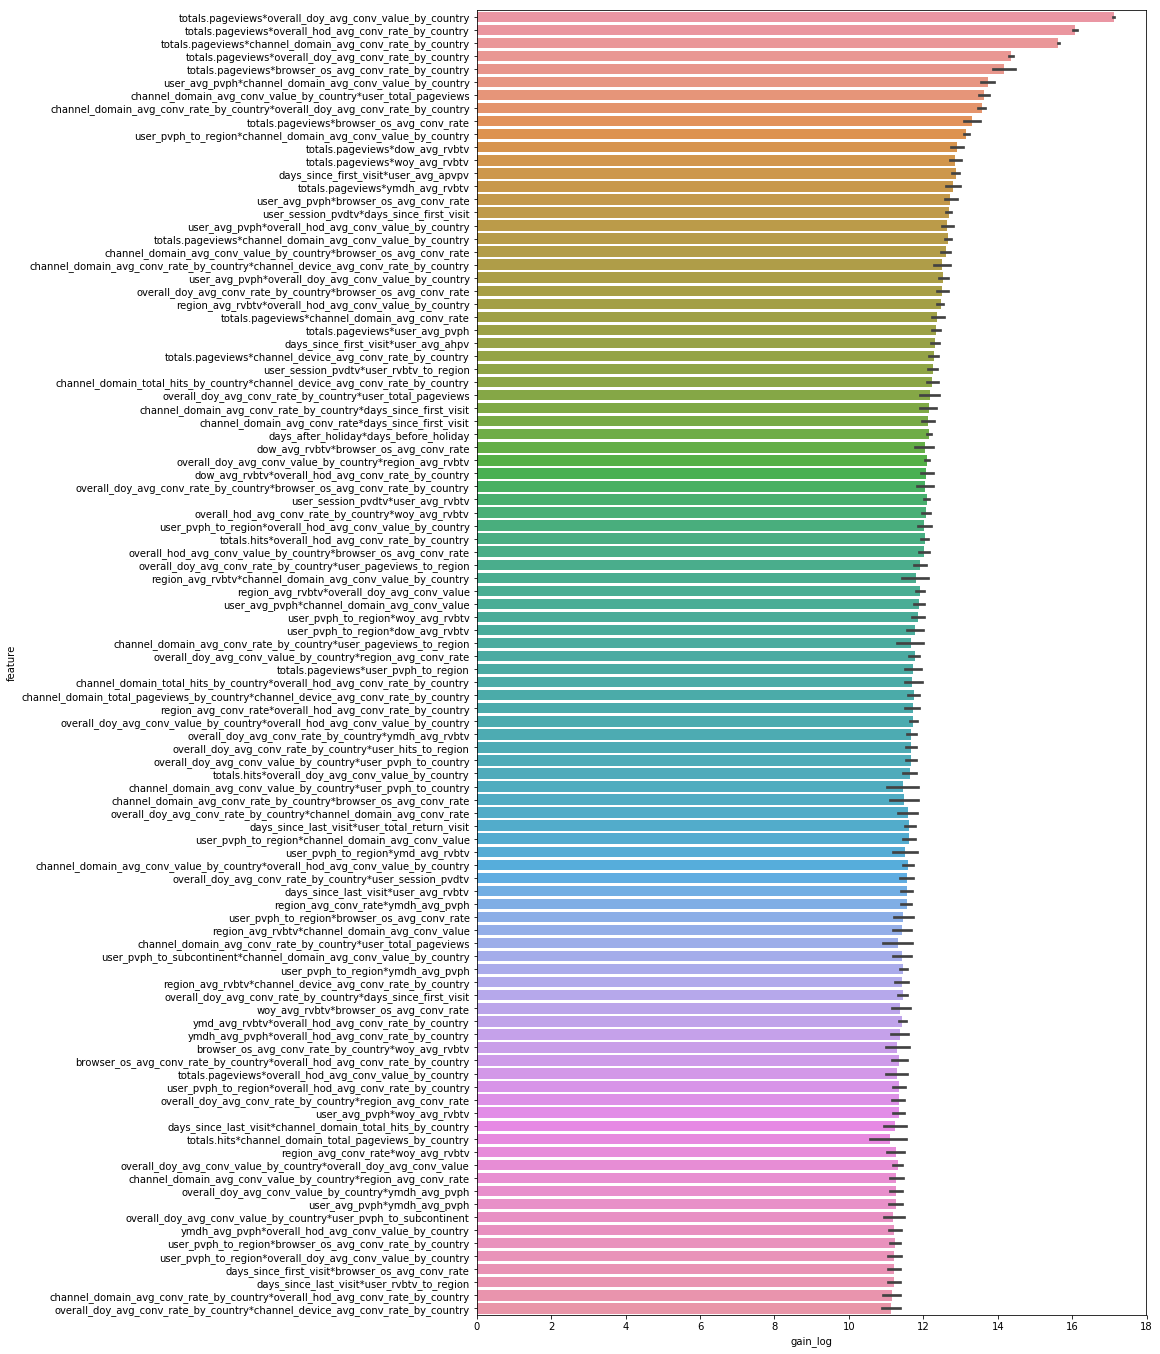

In [20]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

importances['gain_log'] = np.log1p(importances['gain'])
mean_gain = importances[['gain', 'feature']].groupby('feature').mean()
importances['mean_gain'] = importances['feature'].map(mean_gain['gain'])

sorted_importances = importances.sort_values('mean_gain', ascending = False)[['feature', 'mean_gain']].drop_duplicates().reset_index(drop = True)

plt.figure(figsize=(12, 24))
sns.barplot(x = 'gain_log',
            y = 'feature',
            data = importances.sort_values('mean_gain', ascending = False)[:1000]
           );

In [21]:
sorted_importances.to_csv('polynomial_feature_imporatances.csv')

### Save Filtered Feather

In [ ]:
# get top 500 features
poly_imp = pd.read_csv('polynomial_feature_imporatances.csv')
imp_poly_features = poly_imp['feature'].tolist()[:550]

In [ ]:
poly = pd.read_feather('polynomial_features_backup_feather_1')
tdf = pd.read_feather('polynomial_features_backup_feather_2')
poly = poly.join(tdf)
del tdf

tdf = pd.read_feather('polynomial_features_backup_feather_3')
poly = poly.join(tdf)
del tdf

In [ ]:
poly = poly[imp_poly_features].copy()

In [ ]:
poly.to_feather('top_filtered_polynomial_feature_feather')

# Merge Main & Polynomial DataFrames

In [2]:
df = pd.read_feather(PATH+'feathers/joined_processed_all_feateng_float32_noinf')

/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [3]:
# get main feature importance
sorted_importances_5k = pd.read_csv(PATH+'feature_importance/feature_importances_5000est.csv')
sorted_importances_10k = pd.read_csv(PATH+'feature_importance/feature_importances_10000est.csv')

# join dfs
sorted_importances_5k.index = sorted_importances_5k['feature']
sorted_importances_10k.index = sorted_importances_10k['feature']
sorted_importances_5k.drop('feature', 1, inplace = True)
sorted_importances_10k.drop('feature', 1, inplace = True)
sorted_importances = sorted_importances_10k.join(sorted_importances_5k, lsuffix='_10k', rsuffix='_5k').copy()
sorted_importances['mean_gain_sum'] = sorted_importances.mean_gain_10k + sorted_importances.mean_gain_5k
sorted_importances = sorted_importances.drop(['mean_gain_10k', 'mean_gain_5k'], 1).sort_values('mean_gain_sum', ascending = False)
sorted_importances['feature'] = sorted_importances.index
sorted_importances.reset_index(drop = True, inplace = True)

# get top 500 features
main_imp_features = sorted_importances['feature'].tolist()[:550]

In [6]:
keep_features = [

    'date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 'visitId', 'visitStartTime',
    'visitStartTimeLOCAL', 'visitStartTimeLOCALElapsed', 'dataset',
    
    'channelGrouping', 'visitNumber', 'device.browser', 'device.deviceCategory', 'device.isMobile',
    'device.operatingSystem',
    
    'return_visit', 'landing', 'bounce', 'user_has_purchased_before', 'browser_os', 'browser_device',
    'os_device', 'channel_device', 'channel_domain', 'city_country_mismatch', 'is_holiday',
    
    'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro',
    'geoNetwork.networkDomain', 'geoNetwork.region', 'geoNetwork.subContinent',
    
    'trafficSource.adContent', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.gclId',
    'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
    'trafficSource.keyword', 'trafficSource.medium', 'trafficSource.referralPath', 'trafficSource.source',
    'visitStartTimeLOCALYear', 'visitStartTimeLOCALMonth', 'visitStartTimeLOCALWeek', 'visitStartTimeLOCALDay',
    'visitStartTimeLOCALDayofweek', 'visitStartTimeLOCALDayofyear', 'visitStartTimeLOCALIs_month_end',
    'visitStartTimeLOCALIs_month_start', 'visitStartTimeLOCALIs_quarter_end', 'visitStartTimeLOCALIs_quarter_start',
    'visitStartTimeLOCALIs_year_end', 'visitStartTimeLOCALIs_year_start', 'visitStartTimeLOCALHourofday'
    
]

In [7]:
df = df[pd.Series(main_imp_features + keep_features).drop_duplicates().tolist()].copy()

In [8]:
poly = pd.read_feather(PATH+'feathers/top_filtered_polynomial_feature_feather')
poly = poly.astype('float32')

/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [9]:
df = df.join(poly)
del poly

In [15]:
col_list

['date',
 'fullVisitorId',
 'sessionId',
 'totals.transactionRevenue',
 'visitId',
 'visitStartTime',
 'visitStartTimeLOCAL',
 'visitStartTimeLOCALElapsed',
 'dataset',
 'landing',
 'bounce',
 'city_country_mismatch',
 'is_holiday',
 'geoNetwork.continent',
 'geoNetwork.country',
 'trafficSource.adContent',
 'trafficSource.adwordsClickInfo.adNetworkType',
 'trafficSource.adwordsClickInfo.page',
 'trafficSource.adwordsClickInfo.slot',
 'visitStartTimeLOCALIs_month_end',
 'visitStartTimeLOCALIs_month_start',
 'visitStartTimeLOCALIs_quarter_end',
 'visitStartTimeLOCALIs_quarter_start',
 'visitStartTimeLOCALIs_year_end',
 'visitStartTimeLOCALIs_year_start',
 'totals.pageviews',
 'channel_domain_avg_conv_rate_by_country',
 'overall_doy_avg_conv_rate_by_country',
 'visitNumber',
 'user_has_purchased_before',
 'user_pvph_to_region',
 'user_avg_pvph',
 'totals.hits',
 'user_session_pvdtv',
 'days_since_last_visit',
 'user_avg_return_visit',
 'overall_doy_avg_conv_value_by_country',
 'user_pvph

In [16]:
df = df[col_list]

In [18]:
df.to_feather(PATH+'feathers/main&poly_float32')

# Run Final Feature Importance

In [10]:
train = deepcopy(df[df['dataset'] == 'train'])
test = deepcopy(df[df['dataset'] == 'test'])
del df

# drop dataset identifier and reset index
train.drop('dataset', axis = 1, inplace = True)
test.drop('dataset', axis = 1, inplace = True)
train.reset_index(drop = True, inplace = True)
test.reset_index(drop = True, inplace = True)

In [11]:
y_reg = train['totals.transactionRevenue'].fillna(0)
del train['totals.transactionRevenue']

if 'totals.transactionRevenue' in test.columns:
    del test['totals.transactionRevenue']

In [12]:
categorical_features = [
    
    'channelGrouping', 'visitNumber', 'device.browser', 'device.deviceCategory',
    'device.isMobile', 'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.continent',
    'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
    'geoNetwork.subContinent', 'trafficSource.adContent', 'trafficSource.adwordsClickInfo.adNetworkType',
    'trafficSource.adwordsClickInfo.gclId', 'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.slot',
    'trafficSource.campaign', 'trafficSource.keyword', 'trafficSource.medium', 'trafficSource.referralPath',
    'trafficSource.source', 'visitStartTimeLOCALYear', 'visitStartTimeLOCALMonth', 'visitStartTimeLOCALWeek',
    'visitStartTimeLOCALDay', 'visitStartTimeLOCALDayofweek', 'visitStartTimeLOCALDayofyear', 'visitStartTimeLOCALIs_month_end',
    'visitStartTimeLOCALIs_month_start', 'visitStartTimeLOCALIs_quarter_end', 'visitStartTimeLOCALIs_quarter_start',
    'visitStartTimeLOCALIs_year_end', 'visitStartTimeLOCALIs_year_start', 'visitStartTimeLOCALHourofday',
    'return_visit', 'landing', 'bounce', 'user_has_purchased_before', 'browser_os', 'browser_device', 'os_device',
    'channel_device', 'channel_domain', 'city_country_mismatch', 'is_holiday'
    
]

contin_features = [
    
    'totals.hits', 'totals.pageviews', 'days_after_holiday', 'days_before_holiday', 'holiday_anticipation',
    'holiday_gap', 'days_since_last_visit', 'days_since_first_visit'
    
]

excluded_features = [
    
    'date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 'visitId',
    'visitStartTime', 'visitStartTimeLOCAL', 'visitStartTimeLOCALElapsed'

]

# set remaining cols as continuous
additional_contin_vars = deepcopy([c for c in train.columns
                                   if c not in categorical_features + contin_features + excluded_features
                                  ])

# add the additional engineered cols to continuous
contin_features += additional_contin_vars

In [13]:
for f in categorical_features:
    train[f], indexer = pd.factorize(train[f])
    if test[f].dtype == bool:
        test[f] = indexer.get_indexer(deepcopy(test[f].astype(int)))
    else:
        test[f] = indexer.get_indexer(test[f])

train_features = [_f for _f in train.columns if _f not in excluded_features]
X_train, y_train = train[train_features], y_reg

In [15]:
params = {
    'learning_rate': 0.01,
    'objective':'regression',
    'metric':'rmse',
    'num_leaves': 54,
    'verbose': 1,
    'bagging_fraction': 0.99,
    'feature_fraction': 0.99,
    "random_state":42,
    'max_depth': 15,
    "bagging_seed" : 42,
    "verbosity" : -1,
    "bagging_frequency" : 5,
    'lambda_l2': 0.5,
    'lambda_l1': 0.5,
    'min_child_samples': 36
}

In [16]:
n_estimators = 20000

In [19]:
folds = get_folds(df = train, n_splits = 8)

train_features = [_f for _f in train.columns if _f not in excluded_features]

importances = pd.DataFrame()
oof_reg_preds = np.zeros(train.shape[0])
sub_reg_preds = np.zeros(test.shape[0])

for fold_, (trn_, val_) in enumerate(folds):
    
    print("Fold:",fold_)
    trn_x, trn_y = train[train_features].iloc[trn_], y_reg.iloc[trn_]
    val_x, val_y = train[train_features].iloc[val_], y_reg.iloc[val_]
    
    # init & fit
    print('Fitting model...')
    reg = lgb.LGBMRegressor(**params, n_estimators = 10000)
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(val_x, np.log1p(val_y))],
        early_stopping_rounds=50,
        verbose=100,
        eval_metric='rmse'
    )
    
    # feature importance
    imp_df = pd.DataFrame()
    imp_df['feature'] = train_features
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    oof_reg_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_reg_preds[oof_reg_preds < 0] = 0
    _preds = reg.predict(test[train_features], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    sub_reg_preds += np.expm1(_preds) / len(folds)
    
mean_squared_error(np.log1p(y_reg), oof_reg_preds) ** .5

Fold: 0
Fitting model...
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.64829
[200]	valid_0's rmse: 1.56612
[300]	valid_0's rmse: 1.5451
[400]	valid_0's rmse: 1.5374
[500]	valid_0's rmse: 1.53298
[600]	valid_0's rmse: 1.53108
[700]	valid_0's rmse: 1.52909
[800]	valid_0's rmse: 1.52669
[900]	valid_0's rmse: 1.52517
[1000]	valid_0's rmse: 1.52427
[1100]	valid_0's rmse: 1.5234
[1200]	valid_0's rmse: 1.52227
[1300]	valid_0's rmse: 1.52185
[1400]	valid_0's rmse: 1.52115
[1500]	valid_0's rmse: 1.52026
[1600]	valid_0's rmse: 1.51976
[1700]	valid_0's rmse: 1.51957
Early stopping, best iteration is:
[1678]	valid_0's rmse: 1.51937
Fold: 1
Fitting model...
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.66029
[200]	valid_0's rmse: 1.57941
[300]	valid_0's rmse: 1.55815
[400]	valid_0's rmse: 1.55096
[500]	valid_0's rmse: 1.54851
[600]	valid_0's rmse: 1.54659
[700]	valid_0's rmse: 1.5451
[800]	valid_0's rmse: 1.54316
[900]	

1.525958725726878

In [2]:
import numpy as np
np.array([1.51937, 1.54112, 1.53695, 1.50328, 1.52173, 1.52515, 1.55678, 1.50373]).mean()

1.5260137500000002

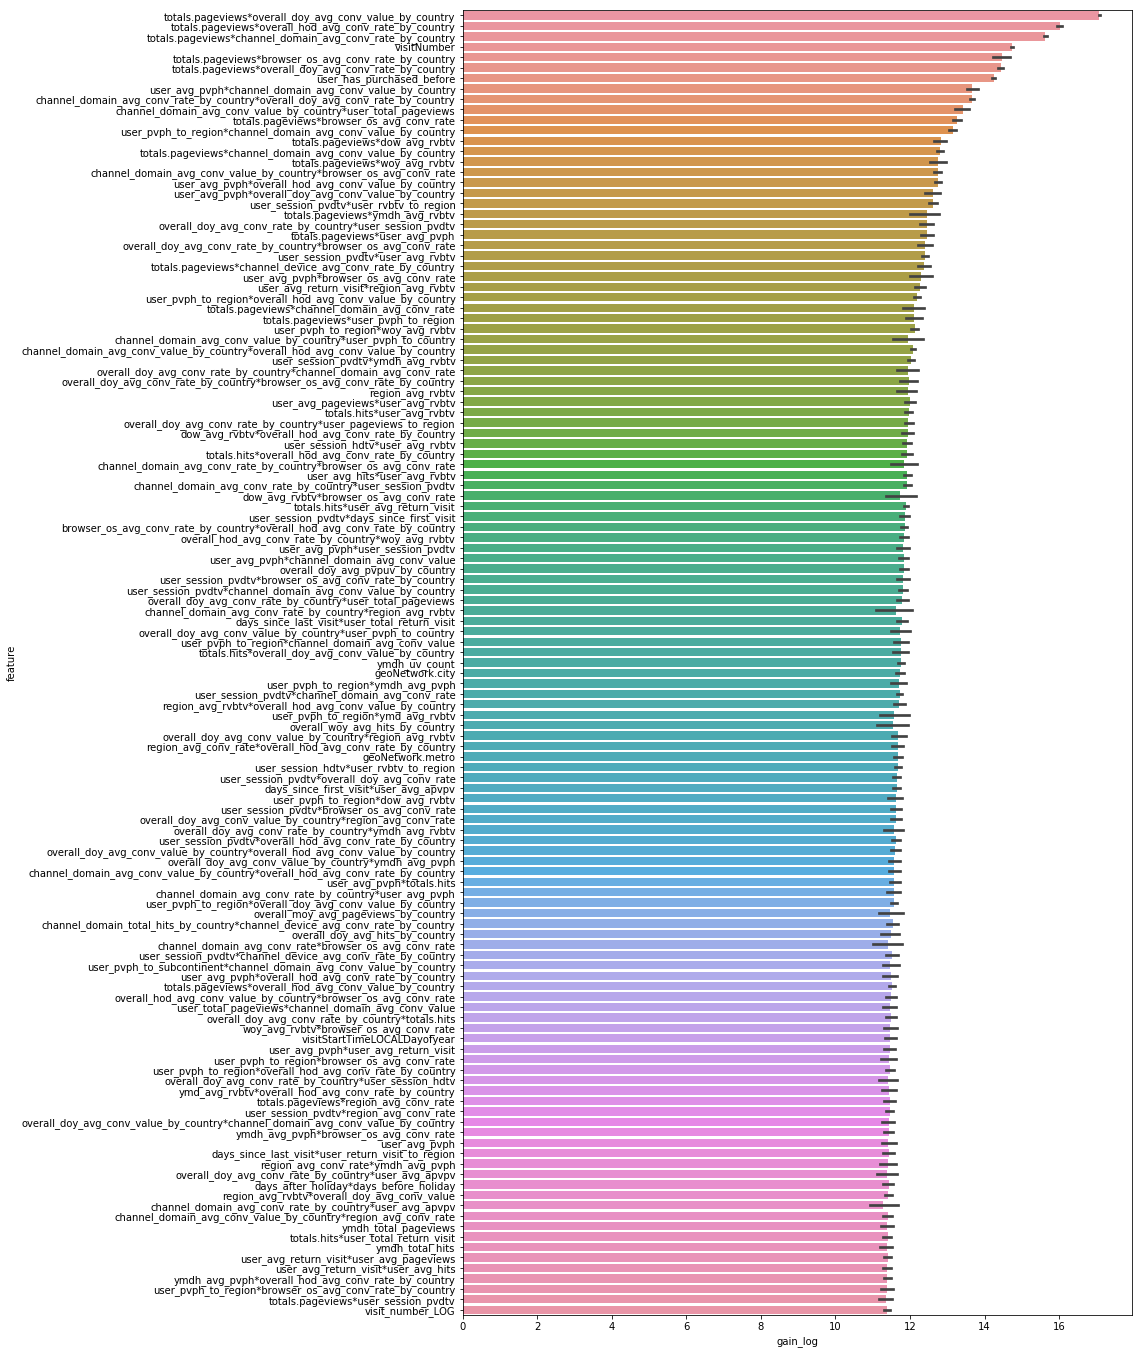

In [20]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

importances['gain_log'] = np.log1p(importances['gain'])
mean_gain = importances[['gain', 'feature']].groupby('feature').mean()
importances['mean_gain'] = importances['feature'].map(mean_gain['gain'])

sorted_importances = importances.sort_values('mean_gain', ascending = False)[['feature', 'mean_gain']].drop_duplicates().reset_index(drop = True)

plt.figure(figsize=(12, 24))
sns.barplot(x = 'gain_log',
            y = 'feature',
            data = importances.sort_values('mean_gain', ascending = False)[:1000]
           );

In [21]:
sorted_importances.to_csv('main&poly_final_feature_imporatances_1.csv')

## Once More with a Lower Learning Rate

In [14]:
n_estimators = 20000

params = {
    'learning_rate': 0.001,
    'objective':'regression',
    'metric':'rmse',
    'num_leaves': 54,
    'verbose': 1,
    'bagging_fraction': 0.99,
    'feature_fraction': 0.99,
    "random_state":42,
    'max_depth': 15,
    "bagging_seed" : 42,
    "verbosity" : -1,
    "bagging_frequency" : 5,
    'lambda_l2': 0.5,
    'lambda_l1': 0.5,
    'min_child_samples': 36
}

In [15]:
folds = get_folds(df = train, n_splits = 8)

train_features = [_f for _f in train.columns if _f not in excluded_features]

importances = pd.DataFrame()
oof_reg_preds = np.zeros(train.shape[0])
sub_reg_preds = np.zeros(test.shape[0])

for fold_, (trn_, val_) in enumerate(folds):
    
    print("Fold:",fold_)
    trn_x, trn_y = train[train_features].iloc[trn_], y_reg.iloc[trn_]
    val_x, val_y = train[train_features].iloc[val_], y_reg.iloc[val_]
    
    # init & fit
    print('Fitting model...')
    reg = lgb.LGBMRegressor(**params, n_estimators = 10000)
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(val_x, np.log1p(val_y))],
        early_stopping_rounds=50,
        verbose=100,
        eval_metric='rmse'
    )
    
    # feature importance
    imp_df = pd.DataFrame()
    imp_df['feature'] = train_features
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    oof_reg_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_reg_preds[oof_reg_preds < 0] = 0
    _preds = reg.predict(test[train_features], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    sub_reg_preds += np.expm1(_preds) / len(folds)
    
mean_squared_error(np.log1p(y_reg), oof_reg_preds) ** .5

Fold: 0
Fitting model...
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.94465
[200]	valid_0's rmse: 1.88759
[300]	valid_0's rmse: 1.83841
[400]	valid_0's rmse: 1.797
[500]	valid_0's rmse: 1.76148
[600]	valid_0's rmse: 1.73138
[700]	valid_0's rmse: 1.70585
[800]	valid_0's rmse: 1.6839
[900]	valid_0's rmse: 1.66499
[1000]	valid_0's rmse: 1.64875
[1100]	valid_0's rmse: 1.63469
[1200]	valid_0's rmse: 1.62247
[1300]	valid_0's rmse: 1.6113
[1400]	valid_0's rmse: 1.60155
[1500]	valid_0's rmse: 1.59327
[1600]	valid_0's rmse: 1.58625
[1700]	valid_0's rmse: 1.58015
[1800]	valid_0's rmse: 1.57469
[1900]	valid_0's rmse: 1.57029
[2000]	valid_0's rmse: 1.56637
[2100]	valid_0's rmse: 1.56291
[2200]	valid_0's rmse: 1.55983
[2300]	valid_0's rmse: 1.55697
[2400]	valid_0's rmse: 1.55442
[2500]	valid_0's rmse: 1.5524
[2600]	valid_0's rmse: 1.5506
[2700]	valid_0's rmse: 1.54888
[2800]	valid_0's rmse: 1.5473
[2900]	valid_0's rmse: 1.54593
[3000]	valid_0's rmse: 1.54478

[5000]	valid_0's rmse: 1.51213
[5100]	valid_0's rmse: 1.51199
[5200]	valid_0's rmse: 1.51183
[5300]	valid_0's rmse: 1.51168
[5400]	valid_0's rmse: 1.51147
[5500]	valid_0's rmse: 1.51131
[5600]	valid_0's rmse: 1.51114
[5700]	valid_0's rmse: 1.51097
[5800]	valid_0's rmse: 1.51077
[5900]	valid_0's rmse: 1.51059
[6000]	valid_0's rmse: 1.51048
[6100]	valid_0's rmse: 1.51041
[6200]	valid_0's rmse: 1.51027
[6300]	valid_0's rmse: 1.51013
[6400]	valid_0's rmse: 1.50996
[6500]	valid_0's rmse: 1.50977
[6600]	valid_0's rmse: 1.50956
[6700]	valid_0's rmse: 1.50936
[6800]	valid_0's rmse: 1.50921
[6900]	valid_0's rmse: 1.50902
[7000]	valid_0's rmse: 1.50883
[7100]	valid_0's rmse: 1.50868
[7200]	valid_0's rmse: 1.50851
[7300]	valid_0's rmse: 1.50838
[7400]	valid_0's rmse: 1.50821
[7500]	valid_0's rmse: 1.50801
[7600]	valid_0's rmse: 1.50787
[7700]	valid_0's rmse: 1.50771
[7800]	valid_0's rmse: 1.50754
[7900]	valid_0's rmse: 1.50739
[8000]	valid_0's rmse: 1.50719
[8100]	valid_0's rmse: 1.50709
[8200]	v

[100]	valid_0's rmse: 1.91554
[200]	valid_0's rmse: 1.86091
[300]	valid_0's rmse: 1.81363
[400]	valid_0's rmse: 1.77348
[500]	valid_0's rmse: 1.73927
[600]	valid_0's rmse: 1.71001
[700]	valid_0's rmse: 1.68474
[800]	valid_0's rmse: 1.66245
[900]	valid_0's rmse: 1.64339
[1000]	valid_0's rmse: 1.62716
[1100]	valid_0's rmse: 1.61322
[1200]	valid_0's rmse: 1.60138
[1300]	valid_0's rmse: 1.59118
[1400]	valid_0's rmse: 1.58233
[1500]	valid_0's rmse: 1.5743
[1600]	valid_0's rmse: 1.56752
[1700]	valid_0's rmse: 1.56166
[1800]	valid_0's rmse: 1.55655
[1900]	valid_0's rmse: 1.5521
[2000]	valid_0's rmse: 1.54792
[2100]	valid_0's rmse: 1.54427
[2200]	valid_0's rmse: 1.54114
[2300]	valid_0's rmse: 1.53834
[2400]	valid_0's rmse: 1.53585
[2500]	valid_0's rmse: 1.53365
[2600]	valid_0's rmse: 1.53161
[2700]	valid_0's rmse: 1.52969


KeyboardInterrupt: 

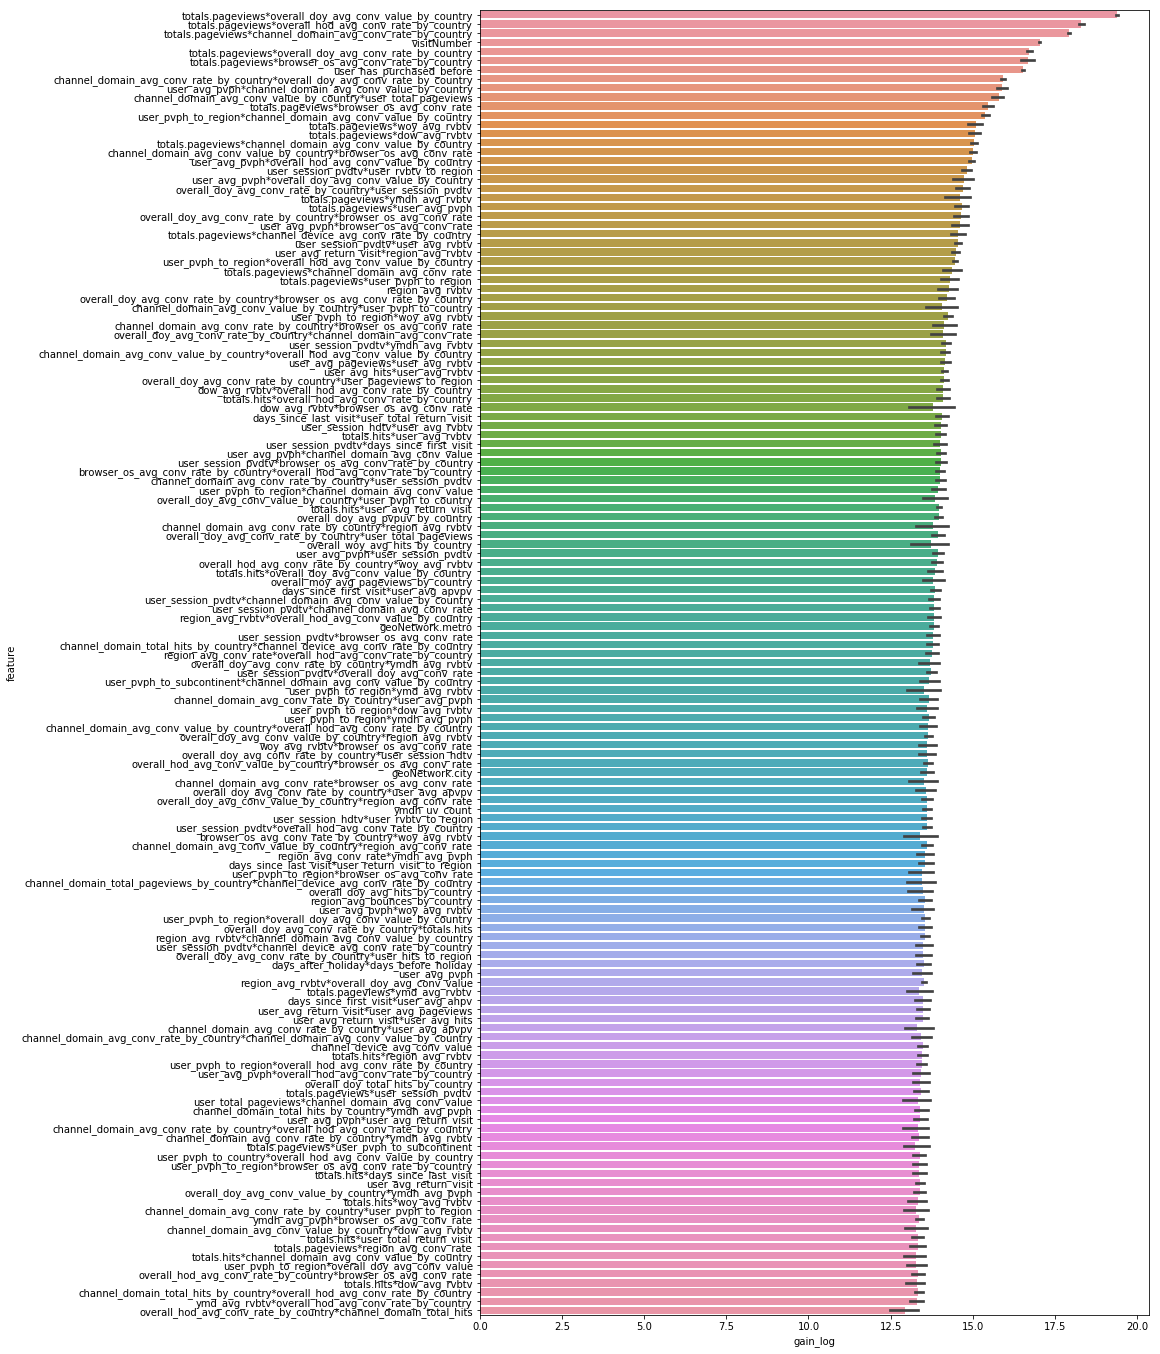

In [16]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

importances['gain_log'] = np.log1p(importances['gain'])
mean_gain = importances[['gain', 'feature']].groupby('feature').mean()
importances['mean_gain'] = importances['feature'].map(mean_gain['gain'])

sorted_importances = importances.sort_values('mean_gain', ascending = False)[['feature', 'mean_gain']].drop_duplicates().reset_index(drop = True)

plt.figure(figsize=(12, 24))
sns.barplot(x = 'gain_log',
            y = 'feature',
            data = importances.sort_values('mean_gain', ascending = False)[:1000]
           );